In [281]:

import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import os
from src.plotCurves import EvalCurves

class InputSettings(object):
    def __init__(self,
            datadir, datasets, algorithms) -> None:
        
        self.datadir = datadir
        self.datasets = datasets
        self.algorithms = algorithms


class OutputSettings(object):
    '''
    Structure for storing the names of directories that output should
    be written to
    '''

    def __init__(self, base_dir: Path) -> None:
        self.base_dir = base_dir

        
class Evaluation(object):
    '''
    The Evaluation object is created by parsing a user-provided configuration
    file. Its methods provide for further processing its inputs into
    a series of jobs to be run, as well as running these jobs.
    '''

    def __init__(self,
            input_settings: InputSettings,
            output_settings: OutputSettings) -> None:

        self.input_settings = input_settings
        self.output_settings = output_settings
        self.runners: Dict[int, Runner] = self.__create_runners()


    def __create_runners(self) -> Dict[int, List[Runner]]:
        '''
        Instantiate the set of runners based on parameters provided via the
        configuration file. Each runner is supplied an interactome, collection,
        the set of algorithms to be run, and graphspace credentials, in
        addition to the custom parameters each runner may or may not define.
        '''
        
        runners: Dict[int, Runner] = defaultdict(list)
        order = 0
        for dataset in self.input_settings.datasets:
            for runner in self.input_settings.algorithms:
                data = {}
                data['name'] = runner[0]
                data['params'] = runner[1]
                data['inputDir'] = Path.cwd().joinpath(self.input_settings.datadir.joinpath(dataset['name']))
                data['exprData'] = dataset['exprData']
                data['cellData'] = dataset['cellData']
                if 'should_run' in data['params'] and \
                        data['params']['should_run'] is False:
                    print("Skipping %s" % (data['name']))
                    continue

                runners[order] = Runner(data)
                order += 1            
        return runners


    def execute_runners(self, parallel=False, num_threads=1):
        '''
        Run each of the algorithms
        '''

        base_output_dir = self.output_settings.base_dir

        batches =  self.runners.keys()

        for batch in batches:
            if parallel==True:
                executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
                futures = [executor.submit(runner.run, base_output_dir)
                    for runner in self.runners[batch]]
                
                # https://stackoverflow.com/questions/35711160/detect-failed-tasks-in-concurrent-futures
                # Re-raise exception if produced
                for future in concurrent.futures.as_completed(futures):
                    future.result()
                executor.shutdown(wait=True)
            else:
                for runner in self.runners[batch]:
                    runner.run(output_dir=base_output_dir)
                    
            
    def evaluate_runners(self):
        '''
        Plot PR and ROC curves for each dataset
        for all the algorithms
        '''
        for dataset in self.input_settings.datasets:              
            EvalCurves(dataset, self.input_settings)
                
                
class ConfigParser(object):
    '''
    Define static methods for parsing a config file that sets a large number
    of parameters for the pipeline
    '''
    @staticmethod
    def parse(config_file_handle) -> Evaluation:
        config_map = yaml.load(config_file_handle)
        return Evaluation(
            ConfigParser.__parse_input_settings(
                config_map['input_settings']),
            ConfigParser.__parse_output_settings(
                config_map['output_settings']))

    @staticmethod
    def __parse_input_settings(input_settings_map) -> InputSettings:
        input_dir = input_settings_map['input_dir']
        dataset_dir = input_settings_map['dataset_dir']
        datasets = input_settings_map['datasets']

        return InputSettings(
                Path(input_dir, dataset_dir),
                datasets,
                ConfigParser.__parse_algorithms(
                input_settings_map['algorithms']))


    @staticmethod
    def __parse_algorithms(algorithms_list):
        algorithms = []
        for algorithm in algorithms_list:
                combos = [dict(zip(algorithm['params'], val))
                    for val in itertools.product(
                        *(algorithm['params'][param]
                            for param in algorithm['params']))]
                for combo in combos:
                    algorithms.append([algorithm['name'],combo])
            

        return algorithms

    @staticmethod
    def __parse_output_settings(output_settings_map):
        output_dir = Path(output_settings_map['output_dir'])
        return OutputSettings(output_dir)

def get_parser() -> argparse.ArgumentParser:
    '''
    :return: an argparse ArgumentParser object for parsing command
        line parameters
    '''
    parser = argparse.ArgumentParser(
        description='Run pathway reconstruction pipeline.')

    parser.add_argument('--config', default='config.yaml',
        help='Configuration file')

    return parser

def parse_arguments():
    '''
    Initialize a parser and use it to parse the command line arguments
    :return: parsed dictionary of command line arguments
    '''
    parser = get_parser()
    opts = parser.parse_args()

    return opts




In [282]:
with open("config-files/config.yaml", 'r') as conf:
    evaluation = ConfigParser.parse(conf)
print(evaluation)


Skipping JUMP3
Skipping JUMP3


In [173]:
evaluation.input_settings.datasets

[{'name': 'HSC_ics',
  'exprData': 'ExpressionData.csv',
  'cellData': 'PseudoTime.csv',
  'trueEdges': 'refNetwork.csv'},
 {'name': 'HSC_ics_dropped',
  'exprData': 'ExpressionData-dropped.csv',
  'cellData': 'PseudoTime.csv',
  'trueEdges': 'refNetwork.csv'}]

In [175]:
for alg in evaluation.input_settings.algorithms:
    print(alg)
    
for runner in evaluation.runners:
    print(runner)

['SCODE', {'should_run': False, 'nGenes': 11, 'z': 10, 'nCells': 2500, 'nIter': 100, 'nRep': 10}]
['SCNS', {'should_run': False}]
['SINCERITIES', {'should_run': False}]
['PIDC', {'should_run': True}]
['GRNVBEM', {'should_run': False}]
['GENIE3', {'should_run': True}]
['GRNBOOST2', {'should_run': True}]
['LEAP', {'should_run': False}]
['JUMP3', {'should_run': False}]
['PPCOR', {'should_run': True, 'pVal': 0.01}]
['GRISLI', {'should_run': True, 'L': 10, 'R': 1000, 'alphaMin': 0.3}]
['SCINGE', {'should_run': False}]
['SCRIBE', {'should_run': True, 'delay': '5,10,20,25,50,75,100', 'method': 'ucRDI', 'lowerDetectionLimit': 0, 'expressionFamily': 'uninormal', 'log': False, 'ignorePT': True}]
0
1
2
3
4
5
6
7
8
9
10
11


In [5]:
Path.cwd().joinpath(evaluation.input_settings.datadir)

PosixPath('/home/adyprat/ModelEval/inputs/simulated')

In [11]:
evaluation.runners[7].generateInputs()
#evaluation.runners[9].run()
#evaluation.runners[7].parseOutput()

Input folder for JUMP3 does not exist, creating input folder...


In [5]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].generateInputs()

Input folder for LEAP does not exist, creating input folder...
Input folder for PPCOR does not exist, creating input folder...
Input folder for GRISLI does not exist, creating input folder...
Input folder for SCINGE does not exist, creating input folder...


In [5]:
#os.system("jupyter nbconvert --to script bench.ipynb")

0

In [6]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].run()


docker run --rm -v ~/ModelEval:/SCODE/data/  scode:base /bin/sh -c "ruby run_R.rb data/inputs/simulated/dataset1/SCODE/ExpressionData.csv data/inputs/simulated/dataset1/SCODE/PseudoTime.csv  data/outputs/simulated/dataset1/SCODE/ 11 4 570 100 5 "
docker run --rm -v ~/ModelEval:/SINCERITIES/data/ sincerities:base /bin/sh -c "Rscript MAIN.R data/inputs/simulated/dataset1/SINCERITIES/ExpressionData.csv data/outputs/simulated/dataset1/SINCERITIES/outFile.txt "
docker run --rm -v ~/ModelEval:/data pidc:base /bin/sh -c "julia runPIDC.jl data/inputs/simulated/dataset1/PIDC/ExpressionData.csv data/outputs/simulated/dataset1/PIDC/outFile.txt "
docker run --rm -v ~/ModelEval:/VBEM/data/ grnvbem:base /bin/sh -c "./GRNVBEM  data/inputs/simulated/dataset1/GRNVBEM/ExpressionData.csv data/outputs/simulated/dataset1/GRNVBEM/outFile.txt "
docker run --rm -v ~/ModelEval:/data/ --expose=41269 arboreto:base /bin/sh -c "python runArboreto.py --algo=GENIE3 --inFile=data/inputs/simulated/dataset1/GENIE3/Expr

In [7]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].parseOutput()

/home/adyprat/ModelEval/src/ppcorRunner.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  part1['absCorVal'] = part1['corVal'].abs()


In [5]:
evaluation.runners[8].run()

docker run --rm -v ~/ModelEval:/runGRISLI/data/ grisli:test /bin/sh -c "./GRISLI  data/inputs/simulated/dataset1/GRISLI/ data/outputs/simulated/dataset1/GRISLI/outFile.txt 10 1000 0.3 "


In [176]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from itertools import product,combinations_with_replacement
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve
trueEdgesDF = pd.read_csv(str(evaluation.input_settings.datadir)+'/'+ dataDict['name'] +
                                '/' +dataDict['trueEdges'],
                                sep = ',', 
                                header = 0, index_col = None)
TrueEdgeDict = {'|'.join(p):0 for p in list(combinations_with_replacement(np.unique(trueEdgesDF.loc[:,['Gene1','Gene2']]),r =2))}
for key in TrueEdgeDict.keys():
    if len(trueEdgesDF.loc[(trueEdgesDF['Gene1'] == key.split('|')[0]) &
                       (trueEdgesDF['Gene2'] == key.split('|')[1])])>0:
        TrueEdgeDict[key] = 1
        
predDF = pd.read_csv('outputs/simulated/CellFate/PIDC/rankedEdges.csv', sep = '\t', header=0, index_col=None)

PredEdgeDict = {'|'.join(p):0 for p in list(combinations_with_replacement(np.unique(trueEdgesDF.loc[:,['Gene1','Gene2']]),r =2))}
for key in PredEdgeDict.keys():
    left = key.split('|')[0]
    right = key.split('|')[1]
    subDF = predDF.query("(((Gene1 == '" + left +"') and (Gene2 == '"+right+"')) or \
                         ((Gene2 == '" + left +"') and (Gene1 == '"+right+"')))")
    if len(subDF)>0:
        PredEdgeDict[key] = max(np.abs(subDF.EdgeWeight.values))


0.5
0.6287878787878788


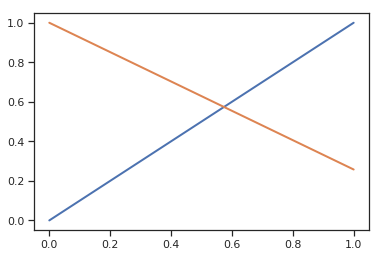

In [159]:
outDF = pd.DataFrame([TrueEdgeDict,PredEdgeDict]).T
outDF.columns = ['TrueEdges','PredEdges']
fpr, tpr, thresholds = roc_curve(y_true=outDF['TrueEdges'],y_score=outDF['PredEdges'], pos_label=1)
plt.plot(tpr,fpr)
fpr, tpr, thresholds = roc_curve(y_true=outDF['TrueEdges'],y_score=outDF['PredEdges'], pos_label=1)
print(auc(fpr, tpr))
prec, recall, thresholds = precision_recall_curve(y_true=outDF['TrueEdges'],
                                                              probas_pred=outDF['PredEdges'], pos_label=1)
plt.plot(recall,prec)
print(auc(recall,prec))


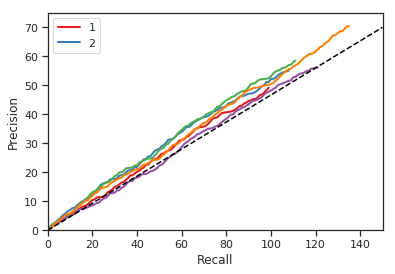

In [18]:
pDict = {}
rDict = {}
#plt.style.use('ggplot')
plt.clf()
sns.set(rc={"lines.linewidth": 2}, palettTruee  = "Set1", style = "ticks")
keys = [1, 2, 3, 4 ,5]
for key in keys:
    pDict[key] = [0]
    rDict[key] = [0]
    for i in range(0,np.random.randint(100,150)):
        pDict[key].append(pDict[key][-1]+np.random.random())
        rDict[key].append(i)
    
for key in pDict.keys():
    sns.lineplot(rDict[key],pDict[key])

plt.plot([0, 150], [0,70], linewidth = 1.5, color = 'k', linestyle = '--')

plt.xlim(0,150)    
plt.ylim(0,75)
plt.xlabel('Recall')unique
plt.ylabel('Precision')
plt.legend(['1','2']) 
        


In [11]:
import pandas as pd

In [19]:
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
newDF = DF.T.copy()
pDF = pd.read_csv('inputs/simulated/dataset1/PseudoTime.csv', header= 0, index_col = 0)
newDF['Time'] = pDF['Time']
DF.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c347,c348,c349,c350,c351,c352,c353,c354,c355,c356
SOX2,1.245513,1.219480,1.273929,1.290600,1.592997,1.419606,1.269637,1.078170,1.065146,1.317938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047353
ESRRB,1.279713,1.276735,1.167757,1.228051,1.388465,1.393951,1.229218,1.164620,1.180736,1.266996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UTF1,1.417324,1.546119,1.554748,1.225030,1.775559,1.606876,1.663052,1.519041,1.575766,1.678738,...,0.000000,0.119715,0.118964,0.225039,0.000000,0.000000,0.000000,0.093533,0.037996,0.838893
EPAS1,0.551417,0.557738,0.490467,0.350676,0.896887,0.276154,0.625784,0.338052,0.428949,0.334456,...,1.305164,1.220422,1.377212,1.146544,1.452294,1.439233,1.463899,1.544450,1.302433,1.333536
FOXQ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.329386,0.924943,0.769071,1.138742,0.625939,1.030036,0.702981,0.954932,0.704600,1.116445


In [3]:
evaluation.runners

defaultdict(list,
            {0: <src.runner.Runner at 0x7fe1ac0ac5f8>,
             1: <src.runner.Runner at 0x7fe1ac0ac898>,
             2: <src.runner.Runner at 0x7fe1ac0ac2e8>,
             3: <src.runner.Runner at 0x7fe1ac0ac8d0>,
             4: <src.runner.Runner at 0x7fe1ac0ac748>,
             5: <src.runner.Runner at 0x7fe1ac0ac860>})

SCODE
SINCERITIES
PIDC
GRNVBEM
GENIE3
GRNBOOST2
LEAP
PPCOR
GRISLI
SCINGE


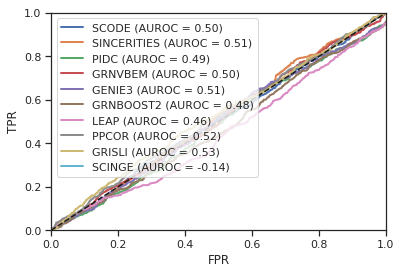

In [8]:
evaluation.evaluate_runners()

In [8]:
dataDict = evaluation.input_settings.datasets[0]

In [9]:
inputSettings = evaluation.input_settings
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

outputs/simulated/dataset1/SCNS/rankedEdges.csv  does not exist. Skipping...
SCODE


/home/adyprat/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


SINCERITIES
PIDC
GRNVBEM
GENIE3
GRNBOOST2


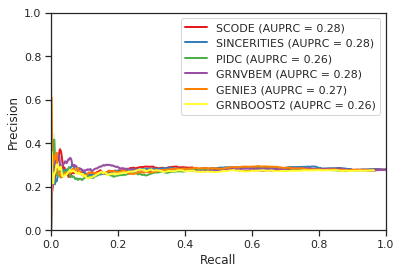

In [10]:
# Read file for trueEdges
trueEdgesFile = pd.read_csv(str(inputSettings.datadir)+'/'+ dataDict['name'] +
                            '/' +'reference_TFTF_network.txt',
                            sep = '\t', header = 0, index_col = None)



# Initialize data dictionaries
precisionDict = {}
recallDict = {}
FPRDict = {}
AUPRC = {}

outDir = "outputs/"+str(inputSettings.datadir).split("inputs/")[1]+ '/' +dataDict['name']
for algo in inputSettings.algorithms:
    tp = 0
    fp = 0
    total = 0 # total predictions made
    totalTrue = trueEdgesFile.shape[0] # Condition Positives
    
    # check if the output rankedEdges file exists
    if Path(outDir + '/' +algo[0]+'/rankedEdges.csv').exists():
        precisionDict[algo[0]] = [] # Initialize Precsion
        recallDict[algo[0]] = [] # Initialize Recall
        FPRDict[algo[0]] = [] # Initialize FPR
        predEdgesFile = pd.read_csv(outDir + '/' +algo[0]+'/rankedEdges.csv', \
                                    sep = '\t', header =  0, index_col = None)
        pOld = 0
        rOld = 0
        AUPRC[algo[0]] = 0 # Initialize AUPRC
        for idx, row in predEdgesFile.iterrows():
            if trueEdgesFile.loc[(trueEdgesFile['Gene1'] == row['Gene1']) & \
                                 (trueEdgesFile['Gene2'] == row['Gene2'])].shape[0] > 0:
                tp += 1
            else:
                fp += 1
            total += 1

            pNew = float(tp)/float(total)
            rNew = float(tp)/float(totalTrue)

            precisionDict[algo[0]].append(pNew)
            recallDict[algo[0]].append(rNew)

            AUPRC[algo[0]] += ((rNew - rOld)*(pOld + pNew)/2) # compute AUPRC

            pOld = pNew
            rOld = rNew
            FPRDict[algo[0]].append(float(fp)) # List of FP values

        FPRDict[algo[0]] = [val/float(total - totalTrue) for val in FPRDict[algo[0]]] # update FPR

    else:
        print(outDir + '/' +algo[0]+'/rankedEdges.csv', \
              ' does not exist. Skipping...')

## Make PR curves
legendList = []
for key in precisionDict.keys():
    print(key)
    sns.lineplot(recallDict[key],precisionDict[key])
    legendList.append(str(key) + ' (AUPRC = ' + str("%.2f" % (AUPRC[key]))+')')

plt.xlim(0,1)    
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legendList) 

In [19]:
fp

1593

In [9]:
import pandas as pd
DF = pd.read_csv('inputs/simulated/HSC/ExpressionData.csv', header= 0, index_col = 0)
DF.head()

,E0_3,E0_6,E0_9,E0_12,E0_15,E0_18,E0_21,E0_24,E0_27,E0_30,...,E29_30,E29_33,E29_36,E29_39,E29_42,E29_45,E29_48,E29_51,E29_54,E29_57
Fli1,0.899597,0.772097,0.743758,0.599874,0.572362,0.574021,0.559713,0.536221,0.545691,0.436200,...,0.363078,0.315353,0.236697,0.150946,0.129677,0.043048,0.034738,0.000000,0.051556,0.038939
Eklf,0.893248,0.827307,0.731184,0.631151,0.545006,0.458842,0.372382,0.310363,0.252155,0.203786,...,0.264309,0.216958,0.173154,0.136426,0.099889,0.075882,0.050606,0.035152,0.015786,0.004587
Scl,0.668060,0.534867,0.453541,0.332549,0.269046,0.195052,0.041264,0.046489,0.004374,0.005459,...,0.002218,0.001137,0.000335,0.015317,0.003627,0.013300,0.019642,0.004098,0.030853,0.055513
Pu1,0.097633,0.012939,0.191090,0.395185,0.520150,0.636482,0.764841,0.788175,0.840814,0.879195,...,0.793056,0.843616,0.891424,0.923499,0.970935,0.947895,0.977581,0.972716,0.992154,0.984303
Gfi1,0.392769,0.042777,0.266949,0.251209,0.075071,0.130255,0.713003,0.434655,0.524331,0.508217,...,0.585858,0.399851,0.125514,0.280587,0.734020,0.391928,0.122775,0.240232,0.496932,0.628144


In [10]:
pDF = {'Cell ID':[],'PseudoTime':[],'Time':[],'Experiment':[]}
maxTime = max([int(ix.split('_')[1]) for ix in DF.columns])
for idx in DF.columns:
    pDF['Cell ID'].append(idx)
    pDF['PseudoTime'].append(float(idx.split('_')[1])/maxTime)
    pDF['Time'].append(idx.split('_')[1])
    pDF['Experiment'].append(idx.split('_')[0].strip('E'))
ptDF = pd.DataFrame(pDF)
ptDF.to_csv("inputs/simulated/HSC/PseudoTime.csv", index = False)

In [27]:
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
DF.T.to_csv('/home/adyprat/ModelEval/Algorithms/GENIE3/temp.tsv', sep = '\t')

In [18]:
pDF

{'Cell ID': ['E0_3',
  0.05263157894736842,
  '0',
  'E0_6',
  0.10526315789473684,
  '0',
  'E0_9',
  0.15789473684210525,
  '0',
  'E0_12',
  0.21052631578947367,
  '0',
  'E0_15',
  0.2631578947368421,
  '0',
  'E0_18',
  0.3157894736842105,
  '0',
  'E0_21',
  0.3684210526315789,
  '0',
  'E0_24',
  0.42105263157894735,
  '0',
  'E0_27',
  0.47368421052631576,
  '0',
  'E0_30',
  0.5263157894736842,
  '0',
  'E0_33',
  0.5789473684210527,
  '0',
  'E0_36',
  0.631578947368421,
  '0',
  'E0_39',
  0.6842105263157895,
  '0',
  'E0_42',
  0.7368421052631579,
  '0',
  'E0_45',
  0.7894736842105263,
  '0',
  'E0_48',
  0.8421052631578947,
  '0',
  'E0_51',
  0.8947368421052632,
  '0',
  'E0_54',
  0.9473684210526315,
  '0',
  'E0_57',
  1.0,
  '0',
  'E1_3',
  0.05263157894736842,
  '1',
  'E1_6',
  0.10526315789473684,
  '1',
  'E1_9',
  0.15789473684210525,
  '1',
  'E1_12',
  0.21052631578947367,
  '1',
  'E1_15',
  0.2631578947368421,
  '1',
  'E1_18',
  0.3157894736842105,
  '1',
 

In [170]:
inDF = pd.read_csv('inputs/simulated/CF_noSig/CF_noSig_ExpressionData.csv', index_col= 0)
inDF.loc[[idx for idx in inDF.index if 'Signal' not in idx],:].to_csv('inputs/simulated/CF_noSig/ExpressionData.csv')

In [177]:
predDF.shape

(1260, 3)

(0, 1)

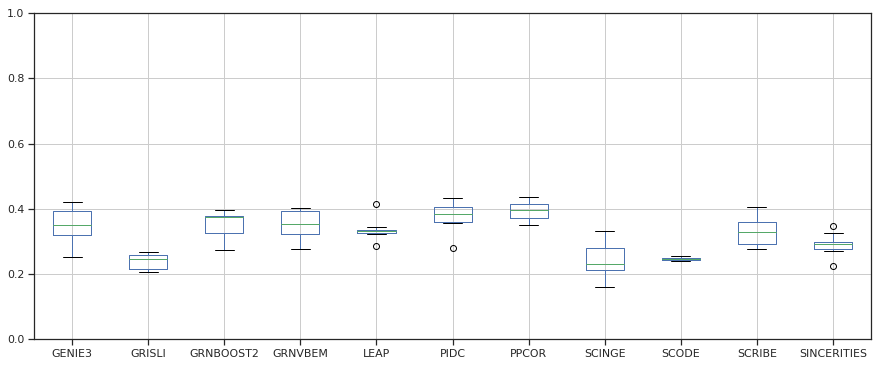

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize =(15,6))
PR = pd.read_csv('outputs/HSC/HSC_1000-AUPRCscores.csv', index_col = 0, header = 0)
ax = PR.T.boxplot()
ax.set_ylim([0,1])

(0, 1)

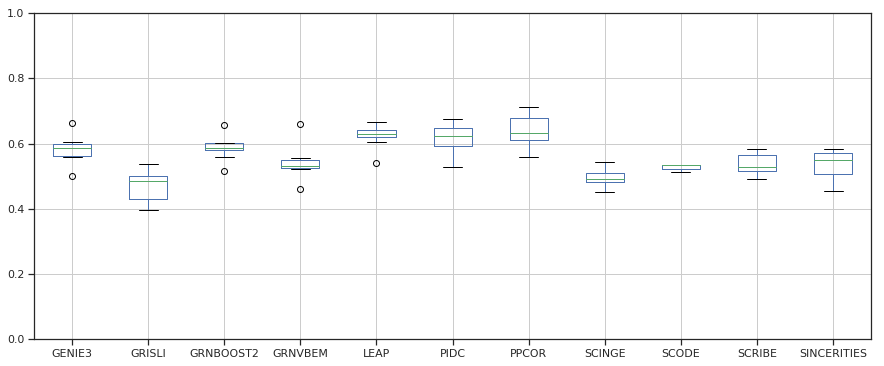

In [206]:
plt.figure(figsize =(15,6))

PR = pd.read_csv('outputs/HSC/HSC_1000-AUROCscores.csv', index_col = 0, header = 0)
ax = PR.T.boxplot()
ax.set_ylim([0,1])

(0, 1)

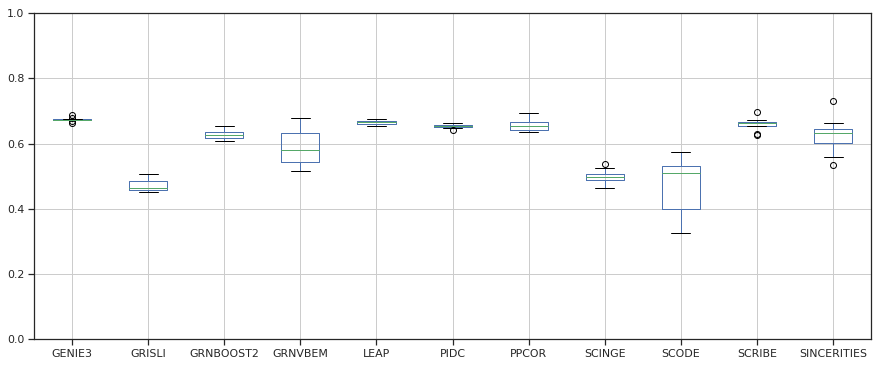

In [283]:
plt.figure(figsize =(15,6))

PR = pd.read_csv('outputs/HSC/HSC_5000-uAUROCscores.csv', index_col = 0, header = 0)
ax = PR.T.boxplot()
ax.set_ylim([0,1])

(0, 1)

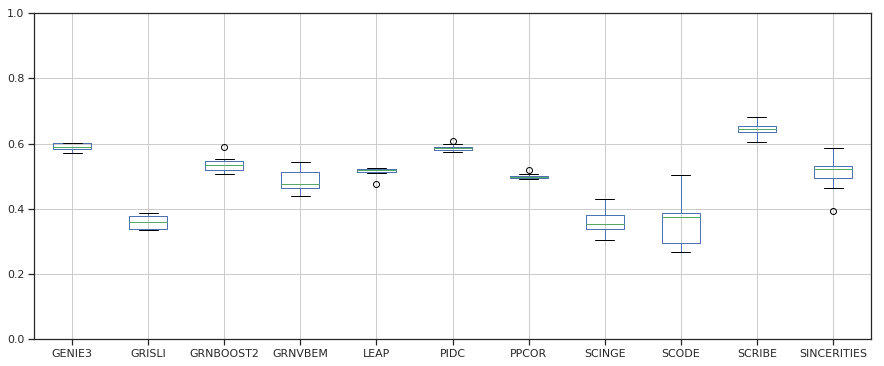

In [284]:
fig = plt.figure(figsize =(15,6))

PR = pd.read_csv('outputs/HSC/HSC_5000-uAUPRCscores.csv', index_col = 0, header = 0)
ax = PR.T.boxplot()
ax.set_ylim([0,1])

In [287]:
trueEdgesDF = pd.read_csv('inputs/HSC/HSC_5000_0/refNetwork.csv', header = 0, index_col = None)
Pred = {}
for algo in evaluation.input_settings.algorithms:
    if algo[0] != 'JUMP3' and algo[0] != 'SCNS':
        for idx in range(10):
            Pred[algo[0]+str(idx)] = {'|'.join(p):0 for p in list(product(np.unique(trueEdgesDF.loc[:,['Gene1','Gene2']]),repeat =2))}
            predDF =  pd.read_csv('outputs/HSC/HSC_1000_'+str(idx)+'/'+algo[0]+'/rankedEdges.csv',sep='\t')
            for key in Pred[algo[0]+str(idx)].keys():
                subDF = predDF.loc[(predDF['Gene1'] == key.split('|')[0]) &
                                   (predDF['Gene2'] == key.split('|')[1])]
                if len(subDF)>0:
                    Pred[algo[0]+'_'+str(idx)+'_1000'][key] = np.abs(subDF.EdgeWeight.values[0])
                    
for algo in evaluation.input_settings.algorithms:
    if algo[0] != 'JUMP3' and algo[0] != 'SCNS':
        for idx in range(10):
            Pred[algo[0]+'_'+str(idx)+'_1000'] = {'|'.join(p):0 for p in list(product(np.unique(trueEdgesDF.loc[:,['Gene1','Gene2']]),repeat =2))}
            predDF =  pd.read_csv('outputs/HSC/HSC_5000_'+str(idx)+'/'+algo[0]+'/rankedEdges.csv',sep='\t')
            for key in Pred[algo[0]+str(idx)].keys():
                subDF = predDF.loc[(predDF['Gene1'] == key.split('|')[0]) &
                                   (predDF['Gene2'] == key.split('|')[1])]
                if len(subDF)>0:
                    Pred[algo[0]+'_'+str(idx)+'_1000'][key] = np.abs(subDF.EdgeWeight.values[0])

/home/adyprat/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


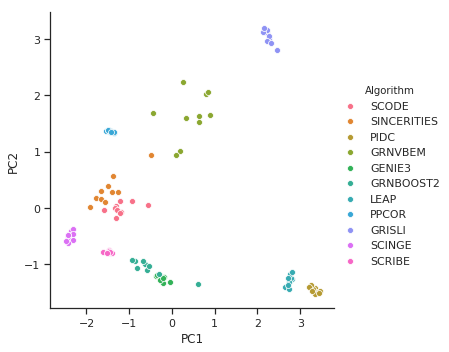

In [288]:

DFFinal = pd.DataFrame(Pred)
DFStd =(DFFinal-DFFinal.min())/(DFFinal.max()-DFFinal.min())
from sklearn.decomposition import PCA
PC = PCA(n_components=2).fit_transform(DFStd.T)
PCdf = pd.DataFrame(PC)
PCdf.index = DFStd.columns
PCdf.columns = ['PC1','PC2']
PCdf.loc[:,'Algorithm'] = [x[:-1] for x in PCdf.index]
#PCdf.plot(x='PC1',y='PC2',kind='scatter',groupby = 'Algorithm')
sns.pairplot(x_vars=["PC1"], y_vars=["PC2"], data=PCdf, hue="Algorithm", size=5)

/home/adyprat/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


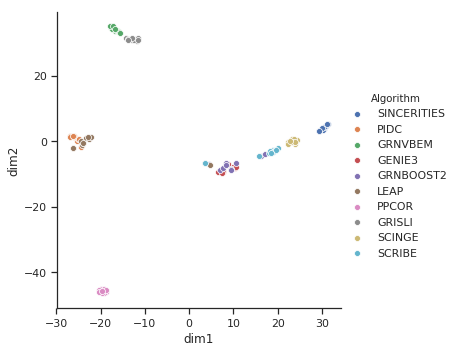

In [246]:
from sklearn.manifold import TSNE
tOut = TSNE(n_components=2, perplexity=10).fit_transform(PCdf[['PC1','PC2']])

PCdf = pd.DataFrame(tOut)
PCdf.index = DFStd.columns
PCdf.columns = ['dim1','dim2']
PCdf.loc[:,'Algorithm'] = [x[:-1] for x in PCdf.index]
#PCdf.plot(x='PC1',y='PC2',kind='scatter',groupby = 'Algorithm')
sns.pairplot(x_vars=["dim1"], y_vars=["dim2"], data=PCdf, hue="Algorithm", size=5)

In [275]:
trueEdgesDF = pd.read_csv('inputs/HSC/HSC_1000_0/refNetwork.csv', header = 0, index_col = None)
Pred = {}
for algo in evaluation.input_settings.algorithms:
    if algo[0] != 'JUMP3' and algo[0] != 'SCNS':
        for idx in range(1):
            Pred[algo[0]+str(idx)] = {'|'.join(p):0 for p in list(product(np.unique(trueEdgesDF.loc[:,['Gene1','Gene2']]),repeat =2))}
            predDF =  pd.read_csv('outputs/HSC/HSC_1000_'+str(idx)+'/'+algo[0]+'/rankedEdges.csv',sep='\t')
            for key in PredEdgeDict.keys():
                subDF = predDF.loc[(predDF['Gene1'] == key.split('|')[0]) &
                                   (predDF['Gene2'] == key.split('|')[1])]
                if len(subDF)>0:
                    Pred[algo[0]+str(idx)][key] = np.abs(subDF.EdgeWeight.values[0])
ensembleDF = pd.DataFrame(Pred)
ensembleFinal = pd.DataFrame(ensembleDF.rank(axis = 0, ascending = False).mean(axis= 1))
ensembleFinal.loc[:,'Gene1'] = [ix.split('|')[0] for ix in ensembleFinal.index]
ensembleFinal.loc[:,'Gene2'] = [ix.split('|')[1] for ix in ensembleFinal.index]
ensembleFinal

,0,Gene1,Gene2
Cebpa|Cebpa,53.863636,Cebpa,Cebpa
Cebpa|EgrNab,22.272727,Cebpa,EgrNab
Cebpa|Eklf,42.136364,Cebpa,Eklf
Cebpa|Fli1,32.136364,Cebpa,Fli1
Cebpa|Fog1,44.954545,Cebpa,Fog1
Cebpa|Gata1,30.590909,Cebpa,Gata1
Cebpa|Gata2,39.590909,Cebpa,Gata2
Cebpa|Gfi1,22.909091,Cebpa,Gfi1
Cebpa|Pu1,39.409091,Cebpa,Pu1
Cebpa|Scl,35.772727,Cebpa,Scl


In [279]:
ensembleFinal.columns = ['EdgeWeight','Gene1','Gene2']
ensembleFinal = ensembleFinal.sort_values(by='EdgeWeight',ascending = True)
ensembleFinal[['Gene1','Gene2','EdgeWeight']].to_csv('outputs/HSC/HSC_1000_0/rankedEdges.csv', index = False,
                                                    sep = '\t')


In [277]:
for algo in evaluation.input_settings.algorithms:
    print(algo[0])

SCODE
SCNS
SINCERITIES
PIDC
GRNVBEM
GENIE3
GRNBOOST2
LEAP
JUMP3
PPCOR
GRISLI
SCINGE
SCRIBE
